In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import psutil
import time
import warnings
warnings.filterwarnings("ignore")

# Memory usage

In [3]:
def measure_usage(func):
    def wrapper(*args, **kwargs):
        process = psutil.Process()
        cpu_times_pre = process.cpu_times()
        memory_use_pre = process.memory_info().rss  # rss = Resident Set Size

        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()

        cpu_times_post = process.cpu_times()
        memory_use_post = process.memory_info().rss

        cpu_time_used = (cpu_times_post.user - cpu_times_pre.user) + (cpu_times_post.system - cpu_times_pre.system)
        memory_used = memory_use_post - memory_use_pre
        execution_time = end_time - start_time

        print(f"Function: {func.__name__}")
        print(f"CPU time used: {cpu_time_used:.2f} sec")
        print(f"Memory used: {memory_used / (1024**2):.2f} MB")  # Convert bytes to MB
        print(f"Execution time: {execution_time:.2f} sec")
        return result
    return wrapper

# Ensemble class (Using Random Forest):

In [10]:
class Ensemble_predictions():
    def __init__(self,df,pred_column,date_col = "timestamp"):
        self.df = df
        self.df.dropna(inplace=True)
        self.model = "Random Forest"
        print("Columns: ",self.df.columns)
        print("Data shape: ",self.df.shape)
        self.df[date_col] = pd.to_datetime(self.df[date_col], errors='coerce')

        self.df = self.df[[date_col,pred_column]]
        self.df.set_index(date_col, inplace=True)
        print("*"*60)

        self.pred_column = pred_column
        self.df['hour'] = self.df.index.hour
        self.df['day_of_week'] = self.df.index.dayofweek
        self.df['day_of_month'] = self.df.index.day
        self.df['month'] = self.df.index.month

        # Lag Features
        self.df['lag1'] = self.df[self.pred_column].shift(1)
        self.df['lag2'] = self.df[self.pred_column].shift(2)

        # Rolling Window Features
        self.df['rolling_mean_3'] = self.df[self.pred_column].rolling(window=3).mean()

        # Drop the first few rows which might have NaN values due to lagging and rolling
        self.df = self.df.dropna()

    def evaluate(self,y_true, y_pred,set):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        print(f'{set} mse for {self.model}: ',mse)
        print(f'{set} rmse for {self.model}: ',rmse)
        print(f'{set} mae for {self.model}: ',mae)
        print(f'{set} mape for {self.model}: ',mape)
    #return mse, rmse, mae, mape

    def plot_results(self,y_train,y_train_pred,y_test,y_test_pred):

        plt.figure(figsize=(18, 7))
        # Plot for training data
        plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
        plt.plot(y_train.index, y_train_pred, label='Predicted Train', color='green')

        # Plot for testing data
        plt.plot(y_test.index, y_test, label='Actual Test', color='red')
        plt.plot(y_test.index, y_test_pred, label='Predicted Test', color='orange')

        plt.title('Train and Test Predictions')
        plt.xlabel('Time')
        plt.ylabel('Average CPU Usage')
        plt.legend()
        plt.show()

    @measure_usage
    def run(self):

        df = self.df
        train = df[:int(0.8 * len(df))]
        test = df[int(0.8 * len(df)):]

        # Preparing training and testing data
        X_train = train.drop(self.pred_column , axis=1)
        y_train = train[self.pred_column ]
        X_test = test.drop(self.pred_column , axis=1)
        y_test = test[self.pred_column]

        print("X_train shape: ",X_train.shape)
        print("y_train shape: ",y_train.shape)
        print("X_test shape: ",X_test.shape)
        print("y_test shape: ",y_test.shape)
        print("*"*60)


        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_train_pred_rf = rf.predict(X_train)
        y_test_pred_rf = rf.predict(X_test)
        print("Train Predictions: ")
        self.evaluate(y_train, y_train_pred_rf,"Train")

        print("*"*60)
        print("Test Predictions: ")
        self.evaluate(y_test, y_test_pred_rf,"Test")

        self.plot_results(y_train,y_train_pred_rf,y_test,y_test_pred_rf)

# Performance on Azure Datset

Columns:  Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')
Data shape:  (8640, 4)
************************************************************
X_train shape:  (6910, 7)
y_train shape:  (6910,)
X_test shape:  (1728, 7)
y_test shape:  (1728,)
************************************************************
Train Predictions: 
Train mse for Random Forest:  9270466.977883805
Train rmse for Random Forest:  3044.7441563920943
Train mae for Random Forest:  1396.076975953565
Train mape for Random Forest:  0.0011449053696178945
************************************************************
Test Predictions: 
Test mse for Random Forest:  108408880.79819225
Test rmse for Random Forest:  10411.9585476601
Test mae for Random Forest:  5599.489138632942
Test mape for Random Forest:  0.004164067331015941


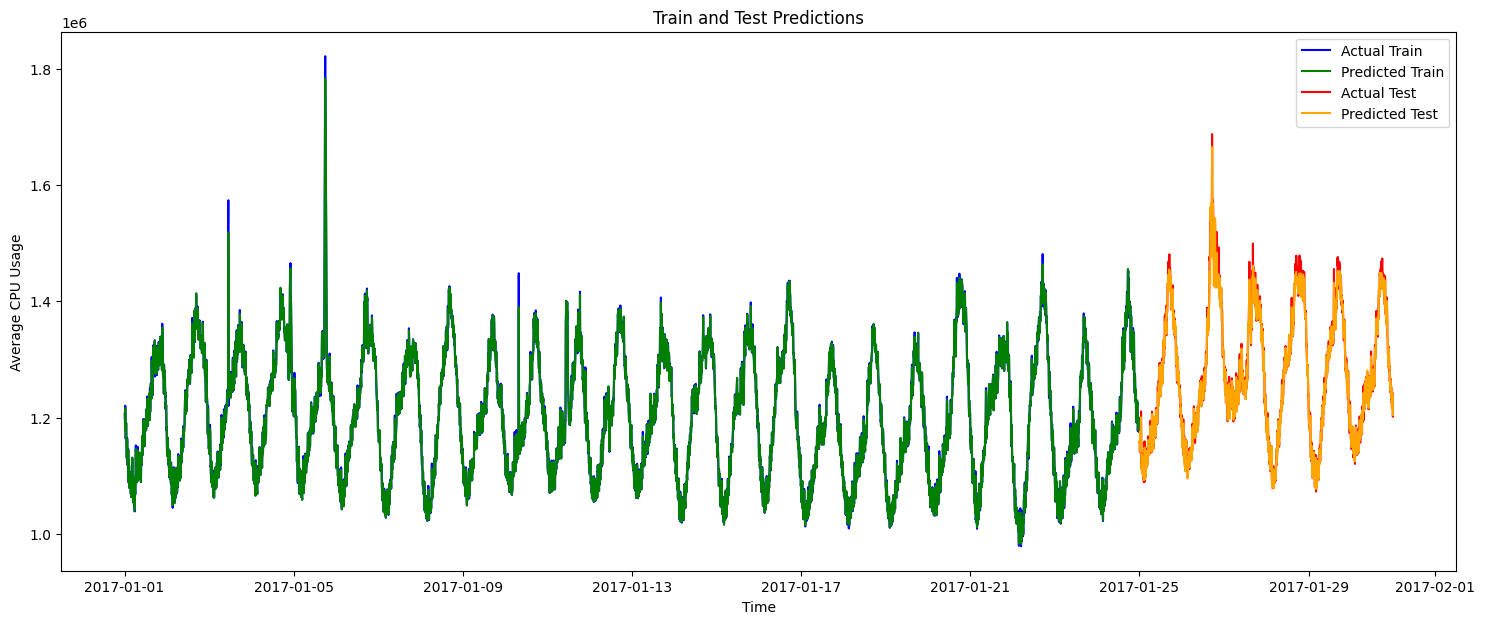

Function: run
CPU time used: 0.55 sec
Memory used: 5.95 MB
Execution time: 2.87 sec


In [11]:
df_azure = pd.read_csv("azure.csv")
azure = Ensemble_predictions(df_azure,"avg cpu")
azure.run()

# Performance on IEEE data while predicting Energy Consumption

Columns:  Index(['timestamp', 'voltage', 'current', 'power', 'frequency', 'energy', 'fp',
       'ESP32_temp', 'WORKSTATION_CPU', 'WORKSTATION_CPU_POWER',
       'WORKSTATION_CPU_TEMP', 'WORKSTATION_GPU', 'WORKSTATION_GPU_POWER',
       'WORKSTATION_GPU_TEMP', 'WORKSTATION_RAM', 'WORKSTATION_RAM_POWER'],
      dtype='object')
Data shape:  (22857, 16)
************************************************************
X_train shape:  (18284, 7)
y_train shape:  (18284,)
X_test shape:  (4571, 7)
y_test shape:  (4571,)
************************************************************
Train Predictions: 
Train mse for Random Forest:  0.00019833288502822268
Train rmse for Random Forest:  0.014083070866406328
Train mae for Random Forest:  0.001220484377428446
Train mape for Random Forest:  8.103949149464238e-05
************************************************************
Test Predictions: 
Test mse for Random Forest:  248.12761808321093
Test rmse for Random Forest:  15.752067105088491
Test mae for Random

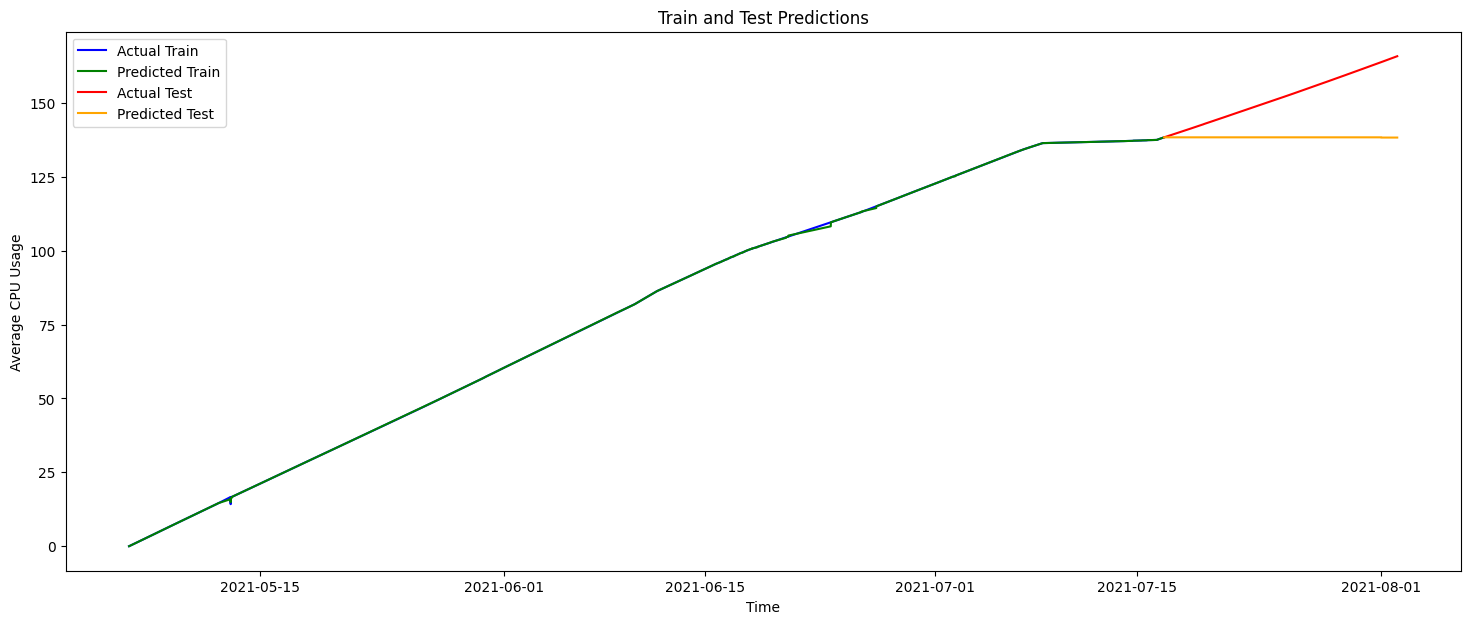

Function: run
CPU time used: 1.27 sec
Memory used: -4.50 MB
Execution time: 4.64 sec


In [12]:
df_workstation = pd.read_csv("workstation_data.csv")
ieee = Ensemble_predictions(df_workstation,"energy")
ieee.run()

# Performance on Turing Dataset

Columns:  Index(['Unnamed: 0', 'cpu_model_name', 'nb_cpu_cores', 'RAM_size', 'day',
       'hour', 'cpu_freq_limit percent', 'current_cpu_frequency_limits',
       'cpu_usage_percent', 'ram_usage_percent', 'energy_consumption',
       'timestamp'],
      dtype='object')
Data shape:  (410, 12)
************************************************************
X_train shape:  (326, 7)
y_train shape:  (326,)
X_test shape:  (82, 7)
y_test shape:  (82,)
************************************************************
Train Predictions: 
Train mse for Random Forest:  0.08953420662576744
Train rmse for Random Forest:  0.2992226706413928
Train mae for Random Forest:  0.11404110429447938
Train mape for Random Forest:  0.016420680066802754
************************************************************
Test Predictions: 
Test mse for Random Forest:  0.6832807309756048
Test rmse for Random Forest:  0.8266079669199934
Test mae for Random Forest:  0.3384048780487751
Test mape for Random Forest:  0.0298683144791

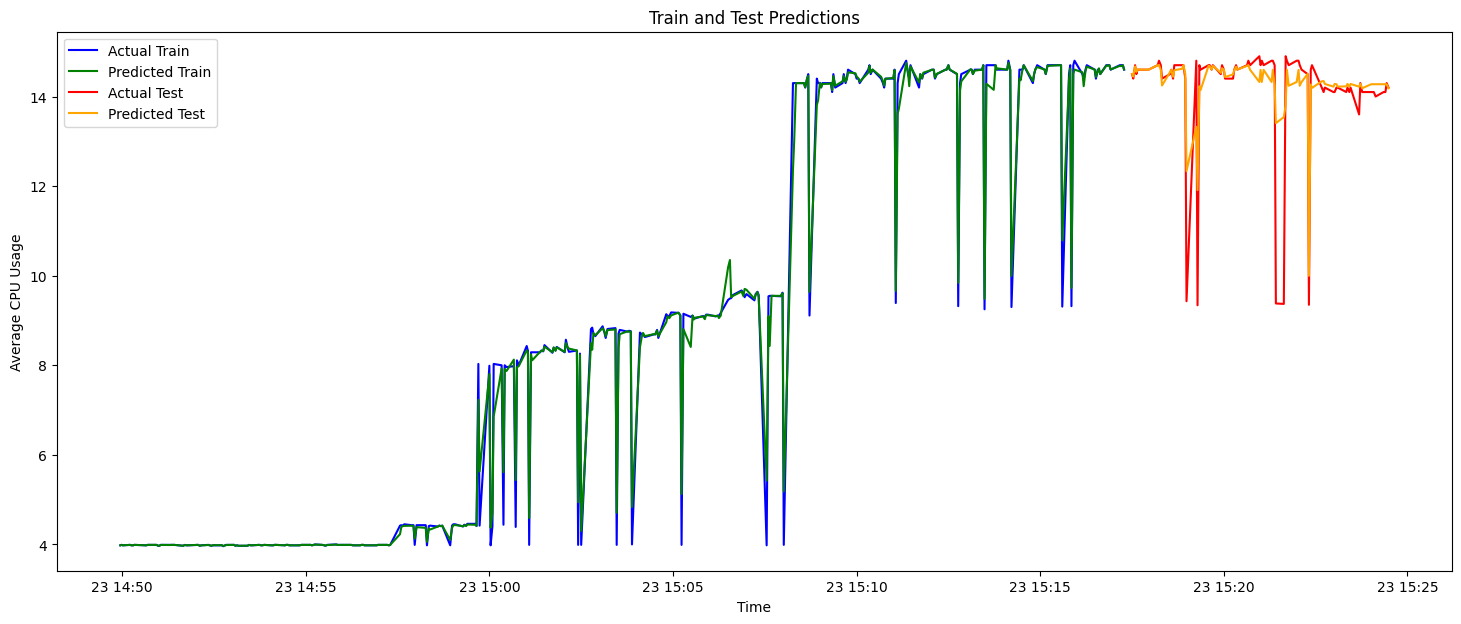

Function: run
CPU time used: 0.14 sec
Memory used: -0.19 MB
Execution time: 0.27 sec


In [13]:
df_turing = pd.read_csv("turing_clean.csv")
df_turing["timestamp"] = df_turing['day'] + " " + df_turing['hour']

turing = Ensemble_predictions(df_turing,"energy_consumption")
turing.run()